In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.image as mpimg

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
walden_snapshot = 'subugoe-collaborative.openalex_walden.works'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
def calculate_changes(df1_openalex, df2_walden, on):
    changes = pd.merge(df1_openalex, df2_walden, on=on, how='outer', suffixes=('_openalex', '_walden'))

    changes['n_openalex'] = changes['n_openalex'].fillna(0)
    changes['n_walden'] = changes['n_walden'].fillna(0)
    changes = changes[[on, 'n_openalex', 'n_walden']]

    changes['change'] = changes['n_walden'] - changes['n_openalex']
    changes['pct_change'] = (changes['n_walden'] - changes['n_openalex']) / changes['n_openalex'] * 100
    #changes['pct_change'] = changes['pct_change'].apply(lambda x: '{:,.2f}'.format(x))

    return changes

In [133]:
oal_by_types = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, type
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                             GROUP BY type
                             ORDER BY n DESC
                             """).to_dataframe()

In [134]:
walden_by_types = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, type
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024
                                GROUP BY type
                                ORDER BY n DESC
                                """).to_dataframe()

In [135]:
types_plot = calculate_changes(oal_by_types, walden_by_types, on='type')

In [136]:
types_plot['n_openalex_total'] = types_plot['n_openalex'].sum()
types_plot['openalex_share'] = types_plot['n_openalex'] / types_plot['n_openalex_total'] * 100

types_plot['n_walden_total'] = types_plot['n_walden'].sum()
types_plot['walden_share'] = types_plot['n_walden'] / types_plot['n_walden_total'] * 100

In [137]:
types_plot

,type,n_openalex,n_walden,change,pct_change,n_openalex_total,openalex_share,n_walden_total,walden_share
0,article,15610743,15789640,178897,1.145986,17281033,90.334548,17471486,90.373767
1,review,693450,688214,-5236,-0.755065,17281033,4.012781,17471486,3.93907
2,paratext,427285,435787,8502,1.989773,17281033,2.472566,17471486,2.494276
3,letter,158396,156083,-2313,-1.460264,17281033,0.916589,17471486,0.893358
4,editorial,113624,112817,-807,-0.710237,17281033,0.657507,17471486,0.645721
5,erratum,72718,72179,-539,-0.74122,17281033,0.420797,17471486,0.413125
6,dataset,55909,1410,-54499,-97.478045,17281033,0.323528,17471486,0.00807
7,book-chapter,47159,103777,56618,120.057677,17281033,0.272895,17471486,0.593979
8,reference-entry,36094,32940,-3154,-8.738294,17281033,0.208865,17471486,0.188536
9,other,21027,20564,-463,-2.201931,17281033,0.121677,17471486,0.1177


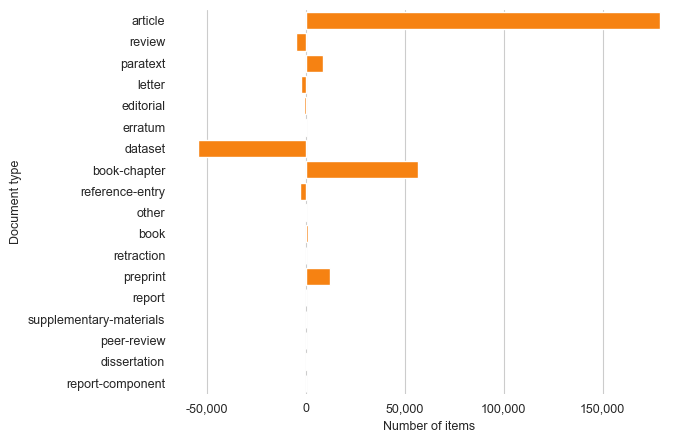

In [138]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=types_plot, 
            x='change', 
            y='type', 
            orient='h',
            saturation=1,
            color='#f68212',
            errorbar=None,)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of items', ylabel='Document type')

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_document_types_changes.png', format='png', bbox_inches='tight', dpi=500)

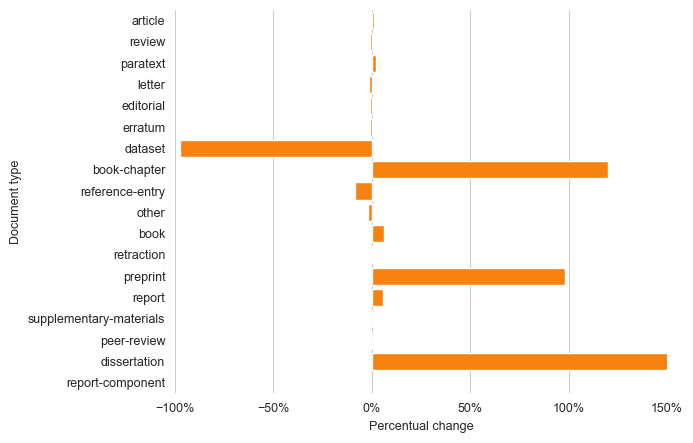

In [139]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=types_plot, 
            x='pct_change', 
            y='type', 
            orient='h',
            saturation=1,
            color='#f68212',
            errorbar=None,)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))

ax.set_xlim(-100, 150)
ax.set(xlabel='Percentual change', ylabel='Document type')

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_document_types_pct_changes.png', format='png', bbox_inches='tight', dpi=500)

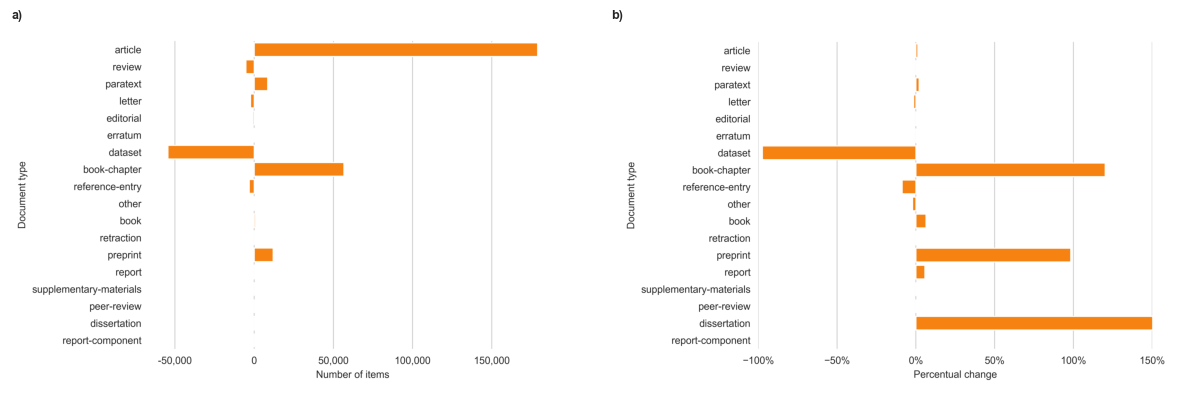

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(15, 14))
filelist =  ['blog_post_document_types_changes', 'blog_post_document_types_pct_changes']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.text(-3800, -100, 'a)', size=9, weight='bold')
plt.text(-50, -100, 'b)', size=9, weight='bold')
plt.show()
fig.savefig('media/blog_post_figure1.png', format='png', bbox_inches='tight', dpi=500)

In [15]:
oal_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM `subugoe-collaborative.openalex.works`
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [16]:
walden_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM {walden_snapshot}
                                    WHERE publication_year BETWEEN 2022 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [17]:
source_type_plot = calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type')

In [18]:
source_type_plot['n_openalex_total'] = source_type_plot['n_openalex'].sum()
source_type_plot['openalex_share'] = source_type_plot['n_openalex'] / source_type_plot['n_openalex_total'] * 100

source_type_plot['n_walden_total'] = source_type_plot['n_walden'].sum()
source_type_plot['walden_share'] = source_type_plot['n_walden'] / source_type_plot['n_walden_total'] * 100

In [19]:
source_type_plot

,source_type,n_openalex,n_walden,change,pct_change,n_openalex_total,openalex_share,n_walden_total,walden_share
0,journal,17281019,17471480,190461,1.10214,28517873,60.597153,60442975,28.905725
1,None,3677588,6219639,2542051,69.122778,28517873,12.89573,60442975,10.290094
2,repository,3593723,28683477,25089754,698.154922,28517873,12.601652,60442975,47.455435
3,ebook platform,2732665,1768359,-964306,-35.288116,28517873,9.582289,60442975,2.925665
4,book series,664146,661015,-3131,-0.471432,28517873,2.328876,60442975,1.093618
5,conference,568721,301813,-266908,-46.931272,28517873,1.994262,60442975,0.499335
6,other,11,54,43,390.909091,28517873,0.000039,60442975,0.000089
7,igsnCatalog,0,5336999,5336999,inf,28517873,0.0,60442975,8.829809
8,metadata,0,135,135,inf,28517873,0.0,60442975,0.000223
9,raidRegistry,0,4,4,inf,28517873,0.0,60442975,0.000007


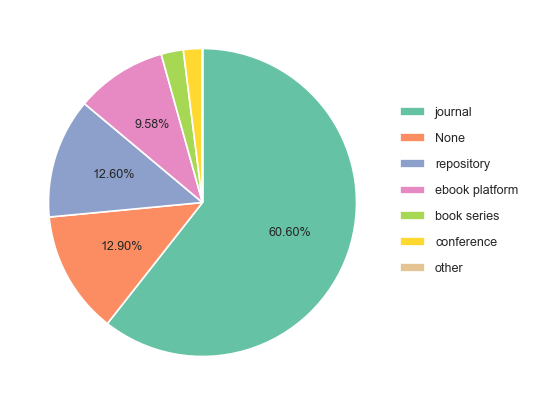

In [22]:
fig, axes = plt.subplots(figsize=(5,5))
plt.box(False)

labels = source_type_plot['source_type'].to_list()[0:7]
data = source_type_plot['openalex_share'].to_list()[0:7]

labels = ['None' if label is None else label for label in labels]



patches, texts, autotexts = plt.pie(data, 
                                    labels=labels, 
                                    startangle=90, 
                                    counterclock=False, 
                                    wedgeprops={'linewidth': 1.2},
                                    autopct='%1.2f%%',
                                    colors=sns.color_palette('Set2'),
                                    labeldistance=1.2)

for i, autotext in enumerate(autotexts, start=1): 
    if i > 4:
        autotext.set_visible(False)
    autotext.set_horizontalalignment('center')
for text in texts: text.set_visible(False)

plt.legend(labels=labels,
           frameon=False, 
           labelspacing=1.1,
           loc=(1, 0.3))

plt.show()
fig.savefig('media/blog_post_source_type_oal_pie_chart.png', format='png', bbox_inches='tight', dpi=500)

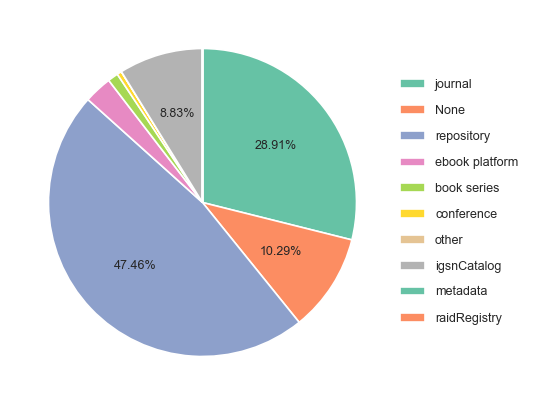

In [23]:
fig, axes = plt.subplots(figsize=(5,5))
plt.box(False)

labels = source_type_plot['source_type'].to_list()
data = source_type_plot['walden_share'].to_list()

labels = ['None' if label is None else label for label in labels]

patches, texts, autotexts = plt.pie(data, 
                                    labels=labels, 
                                    startangle=90, 
                                    counterclock=False, 
                                    wedgeprops={'linewidth': 1.2},
                                    autopct='%1.2f%%',
                                    colors=sns.color_palette('Set2'),
                                    labeldistance=1.2)

for i, autotext in enumerate(autotexts, start=1): 
    if i > 3 and not i == 8:
        autotext.set_visible(False)
    autotext.set_horizontalalignment('center')
for text in texts: text.set_visible(False)

plt.legend(labels=labels,
           frameon=False, 
           labelspacing=1.1,
           loc=(1, 0.17))

plt.show()
fig.savefig('media/blog_post_source_type_walden_pie_chart.png', format='png', bbox_inches='tight', dpi=500)

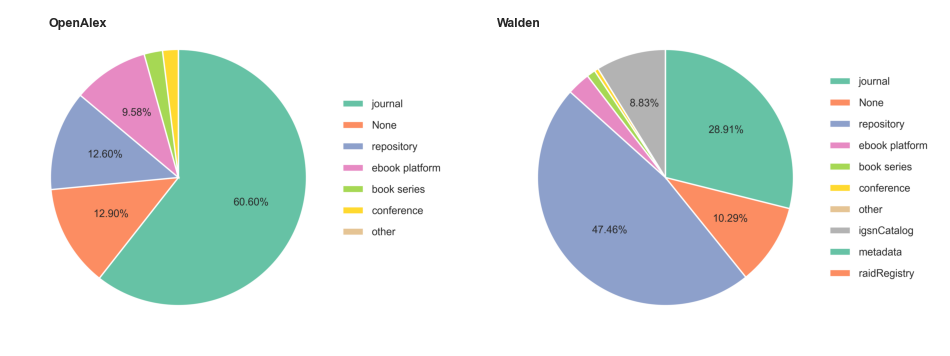

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
filelist =  ['blog_post_source_type_oal_pie_chart', 'blog_post_source_type_walden_pie_chart']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.text(-2700, 100, 'OpenAlex', size=9, weight='bold')
plt.text(0, 100, 'Walden', size=9, weight='bold')
plt.show()
fig.savefig('media/blog_post_figure2.png', format='png', bbox_inches='tight', dpi=500)

In [77]:
oal_by_oa = client.query(f"""
                          SELECT COUNT(DISTINCT(doi)) AS n, open_access.oa_status, publication_year
                          FROM {openalex_snapshot}
                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                          GROUP BY oa_status, publication_year
                          ORDER BY n DESC
                          """).to_dataframe()

In [78]:
walden_by_oa = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, open_access.oa_status, publication_year
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY oa_status, publication_year
                             ORDER BY n DESC
                             """).to_dataframe()

In [79]:
oa_plot = pd.merge(oal_by_oa, walden_by_oa, on=['oa_status', 'publication_year'], how='inner', suffixes=('_openalex', '_walden'))

In [108]:
oa_plot = oa_plot.sort_values(by=['oa_status', 'publication_year'])

In [123]:
oa_plot

,n_openalex,oa_status,publication_year,n_walden
10,537456,bronze,2022,350181
9,578841,bronze,2023,437680
14,352777,bronze,2024,409233
2,1885405,closed,2022,1869346
1,1958314,closed,2023,1788952
0,2796075,closed,2024,1988077
13,374618,diamond,2022,1329500
12,401654,diamond,2023,1477448
11,402212,diamond,2024,1605821
3,1531155,gold,2022,967509


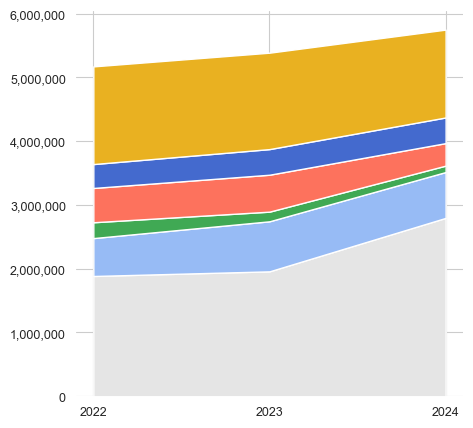

In [130]:
fig, ax = plt.subplots(figsize=(5,5))
plt.box(False)

plt.stackplot([2022, 2023, 2024], 
              oa_plot[oa_plot.oa_status == 'closed']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'hybrid']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'green']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'bronze']['n_openalex'].tolist(),
              oa_plot[oa_plot.oa_status == 'diamond']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'gold']['n_openalex'].tolist(),
              colors=['#e5e5e5', '#97bbf5ff', '#40a954', '#fd725d', '#446ace', '#e9b121'],
             )

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks([2022, 2023, 2024])

plt.show()
fig.savefig('media/blog_post_oa_oal_area_chart.png', format='png', bbox_inches='tight', dpi=500)

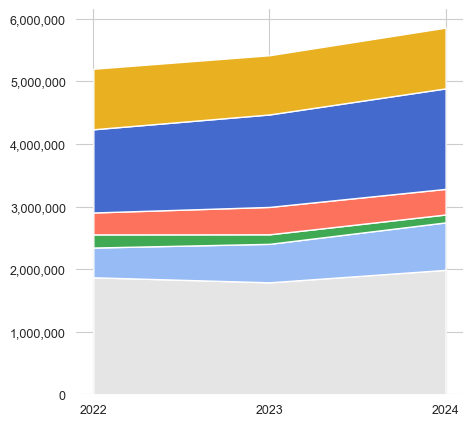

In [131]:
fig, ax = plt.subplots(figsize=(5,5))
plt.box(False)

plt.stackplot([2022, 2023, 2024], 
              oa_plot[oa_plot.oa_status == 'closed']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'hybrid']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'green']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'bronze']['n_walden'].tolist(),
              oa_plot[oa_plot.oa_status == 'diamond']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'gold']['n_walden'].tolist(),
              colors=['#e5e5e5', '#97bbf5ff', '#40a954', '#fd725d', '#446ace', '#e9b121'],
             )

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks([2022, 2023, 2024])

plt.show()
fig.savefig('media/blog_post_oa_walden_area_chart.png', format='png', bbox_inches='tight', dpi=500)

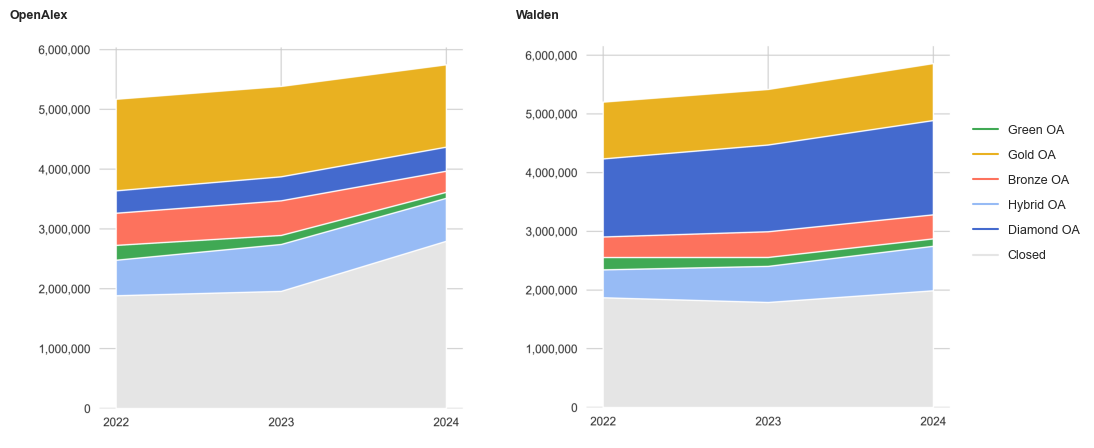

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
filelist =  ['blog_post_oa_oal_area_chart', 'blog_post_oa_walden_area_chart']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.text(-2700, -100, 'OpenAlex', size=9, weight='bold')
plt.text(0, -100, 'Walden', size=9, weight='bold')

green_oa_patch = Line2D([0], [0], color='#40a954', label='Green OA')
gold_oa_patch = Line2D([0], [0], color='#e9b121', label='Gold OA')
bronze_oa_patch = Line2D([0], [0], color='#fd725d', label='Bronze OA')
hybrid_oa_patch = Line2D([0], [0], color='#97bbf5ff', label='Hybrid OA')
diamond_oa_patch = Line2D([0], [0], color='#446ace', label='Diamond OA')
closed_oa_patch = Line2D([0], [0], color='#e5e5e5', label='Closed')

lgd = fig.legend(handles=[green_oa_patch, 
                          gold_oa_patch, 
                          bronze_oa_patch,
                          hybrid_oa_patch,
                          diamond_oa_patch,
                          closed_oa_patch], frameon=False,
                 bbox_to_anchor=(1.01, 0.65), labelspacing=1.05)


plt.show()
fig.savefig('media/blog_post_figure3.png', format='png', bbox_inches='tight', dpi=500)

In [145]:
oal_by_host = client.query(f"""
                            SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                            FROM {openalex_snapshot}
                            WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                            GROUP BY host_organization_name
                            ORDER BY n DESC
                            """).to_dataframe()

In [146]:
walden_by_host = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY host_organization_name
                             ORDER BY n DESC
                             """).to_dataframe()

In [147]:
host_plot = calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False)

In [152]:
oal_by_host_references = client.query(f"""
                                      SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                      FROM {openalex_snapshot}
                                      WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                      GROUP BY host_organization_name
                                      ORDER BY n DESC
                                      """).to_dataframe()

In [153]:
walden_by_host_references = client.query(f"""
                                          SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                          FROM {walden_snapshot}
                                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                          GROUP BY host_organization_name
                                          ORDER BY n DESC
                                          """).to_dataframe()

In [154]:
ref_plot = calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False)

In [156]:
host_plot_merge = pd.merge(host_plot, ref_plot, on=['host_organization_name'], how='outer', suffixes=('_items', '_refs'))

In [161]:
host_top_20_plot = host_plot_merge.sort_values(by=['n_openalex_items'], ascending=False).head(20)

In [202]:
host_top_20_plot

,host_organization_name,n_openalex_items,n_walden_items,change_items,pct_change_items,n_openalex_refs,n_walden_refs,change_refs,pct_change_refs
0,None,4406230,4583234,177004,4.01713,33877276,38620785,4743509,14.002038
1,Elsevier BV,2488907,2486832,-2075,-0.08337,99552763,109168132,9615369,9.658566
2,Multidisciplinary Digital Publishing Institute,808028,806939,-1089,-0.134773,42306176,45172150,2865974,6.774363
3,Springer Science+Business Media,786127,792822,6695,0.851644,31926819,33222209,1295390,4.057373
4,Wiley,736327,733618,-2709,-0.367907,31252965,32518662,1265697,4.049846
5,Taylor & Francis,367153,367539,386,0.105133,13892854,14534769,641915,4.620469
6,Frontiers Media,267408,267480,72,0.026925,15792532,16325262,532730,3.373303
7,Oxford University Press,252446,252470,24,0.009507,6495768,7191019,695251,10.703138
8,SAGE Publishing,228762,228465,-297,-0.129829,7613836,7757894,144058,1.892055
9,Institute of Electrical and Electronics Engineers,219312,218626,-686,-0.312796,6484987,8254147,1769160,27.280857


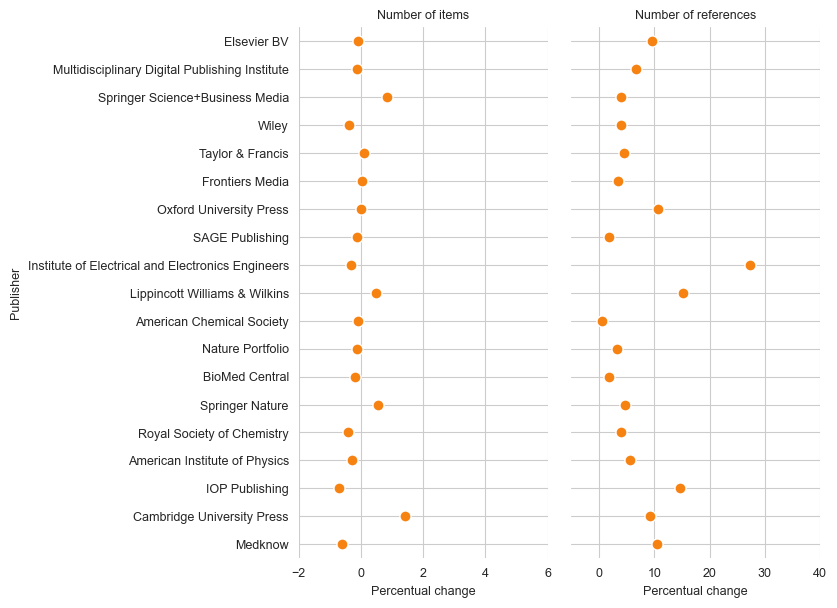

In [240]:
g = sns.PairGrid(host_top_20_plot,
                 x_vars=['pct_change_items', 'pct_change_refs'], 
                 y_vars=['host_organization_name'], 
                 height=6, 
                 aspect=.5)

g.map(sns.stripplot, 
      size=8, 
      orient='h', 
      jitter=False,
      color='#f68212',
      linewidth=1, 
      edgecolor='w')

plt.box(False)

g.set(xlabel='Percentual change', ylabel='Publisher')

titles = ['Number of items', 'Number of references']

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    if title == 'Number of items':
        ax.set_xlim(-2, 6)

    if title == 'Number of references':
        ax.set_xlim(-5, 40)

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

fig = g.fig.get_figure()

plt.show()
fig.savefig('media/blog_post_figure4.png', format='png', bbox_inches='tight', dpi=500)

In [203]:
oal_by_pubyear = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                               FROM `subugoe-collaborative.openalex.works`
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY publication_year DESC
                               """).to_dataframe()

In [204]:
walden_by_pubyear = client.query(f"""
                                  SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                                  FROM {walden_snapshot}
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [205]:
calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False)

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,5747463,5858802,111339,1.937185
1,2023,5385802,5417422,31620,0.587099
2,2022,5170934,5201685,30751,0.594689


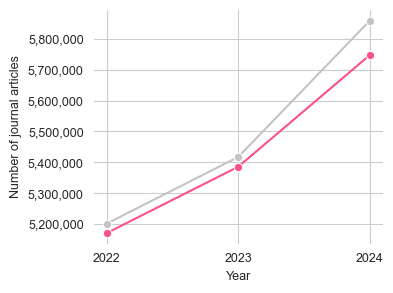

In [224]:
fig, ax = plt.subplots(figsize=(4,3))
plt.box(False)

sns.lineplot(data=oal_by_pubyear,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=walden_by_pubyear,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Year', ylabel='Number of journal articles')
ax.set_xticks(range(2022,2025))

#oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
#walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

#lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
#                 bbox_to_anchor=(1.25, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_pubyear.png', format='png', bbox_inches='tight', dpi=500)

In [211]:
oal_grants = client.query(f"""
                           SELECT COUNT(grant.award_id) AS n, publication_year
                           FROM `subugoe-collaborative.openalex.works`, UNNEST(grants) AS grant
                           WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                           GROUP BY publication_year
                           ORDER BY n DESC
                           """).to_dataframe()

In [212]:
walden_grants = client.query(f"""
                               SELECT COUNT(grant.id) AS n, publication_year
                               FROM {walden_snapshot}, UNNEST(awards) AS grant
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2022 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY n DESC
                               """).to_dataframe()

In [214]:
calculate_changes(oal_grants, walden_grants, on='publication_year')

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,1829832,1856745,26913,1.470791
1,2023,1798571,1837831,39260,2.182844
2,2022,1792249,1812408,20159,1.124788


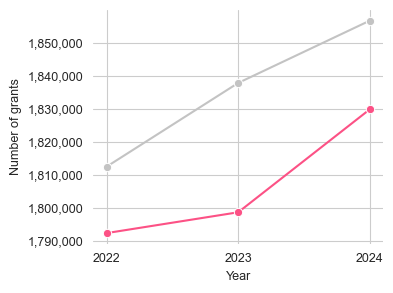

In [243]:
fig, ax = plt.subplots(figsize=(4,3))
plt.box(False)

sns.lineplot(data=oal_grants,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=walden_grants,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Year', ylabel='Number of grants')
ax.set_xticks(range(2022,2025))

#oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
#walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

#lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
#                 bbox_to_anchor=(1.25, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_grants.png', format='png', bbox_inches='tight', dpi=500)

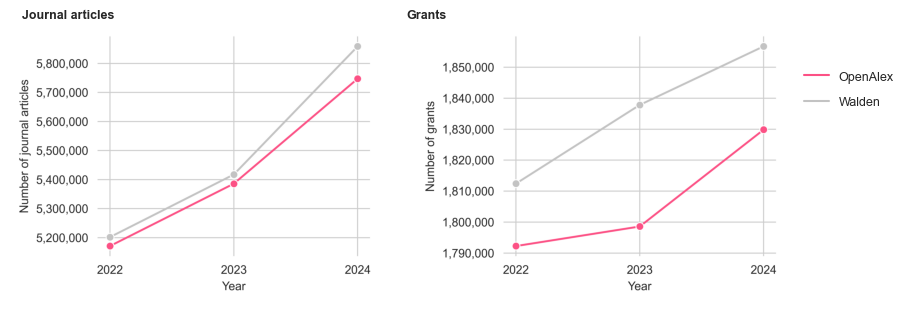

In [237]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
filelist =  ['blog_post_pubyear', 'blog_post_grants']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.text(-2100, -50, 'Journal articles', size=9, weight='bold')
plt.text(-50, -50, 'Grants', size=9, weight='bold')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex')
walden_patch = Line2D([0], [0], color='#c3c3c3', label='Walden')

lgd = fig.legend(handles=[oal_patch, walden_patch], frameon=False,
                 bbox_to_anchor=(1.02, 0.6), labelspacing=1.05)

plt.show()
fig.savefig('media/blog_post_figure5.png', format='png', bbox_inches='tight', dpi=500)